#  Demonstration of the parton evolution using MC method
     1. generate starting distribution in x and add intrisnic transverse mom.
     2. evolve sarting distribution to large values of t

   Plot starting distribution and intrinsic kt
   Plot evolved distribution as function of x and kt

###   Authors: H. Jung, A. Bermudez Martinez, L.I. Estevez Banos, J. Lidrych, M. Mendizabal Morentin, S. Taheri Monfared, P. L.S. Connor, Q. Wang, H. Yang, R. Zlebcik 

In [1]:
# First lets load the libraries which will be needed

from math import pi, sin, cos, sqrt, log, log10, exp
from ROOT import gRandom, gStyle, TCanvas, TH1D, TLorentzVector

Welcome to JupyROOT 6.22/06


Define function which returns 2D point according to the Gaussian distribution

In [2]:
def gauss2D(sigma):
    kT  = sigma * sqrt(-2*log(gRandom.Uniform()));
    phi = 2*pi * gRandom.Uniform()
    kx, ky = kT*cos(phi), kT*sin(phi)
    return (kx, ky)

Get starting PDF at the starting scale $q^2$ ($q^2$=1)

In [3]:
Eb = 3500 # Beam energy
def get_starting_pdf(q2):
    xmin = 0.00001
    xmax = 0.999
    # get x value according to g(x)\sim 1/x            
    x = xmin * (xmax/xmin)**gRandom.Uniform()
    weightx = x*log(xmax/xmin) 
    # use: xg(x) = 3 (1-x)**5
    pdf = 3.*pow((1-x),5)/x

    # now generate instrinsic kt according to a gauss distribution  
    kx, ky = gauss2D(0.7)
    pVec = TLorentzVector()
    pVec.SetXYZM(kx, ky, x*Eb, 0.)
    return pVec, weightx * pdf


Calculate Sudakov form factor

In [4]:
def sudakov(t0):
    #   here we calculate  from the sudakov form factor the next t > t0
    epsilon = 0.1
    as2pi = 0.1/(2.*pi)
    Ca = 3.
    # for Pgg use fact = 2*Ca
    fac = 2.*Ca 
    # use fixed alphas and only the 1/(1-z) term of the splitting fct

    r1 = gRandom.Uniform()
    Pint=log((1.-epsilon)/epsilon) # for 1/(1-z) splitting fct 
    t2 = -log(r1)/fac/as2pi/Pint
    t2 = t0 * exp(t2)
    assert(t2 >= t0)
    return t2

Splitting function which is needed to get the z on the branching point

In [5]:
def splitting():
    epsilon = 0.1

    as2pi = 0.1/2./pi

    #	here we calculate  the splitting variable z for 1/z and  1/(1-z)
    #	use Pgg=6(1/z + 1/(1-z))  // for large z we use z -> 1-z

    g0 = 6.*as2pi * log((1.-epsilon)/epsilon)
    g1 = 6.*as2pi * log((1.-epsilon)/epsilon)
    gtot = g0 + g1 

    zmin = epsilon
    zmax = 1.-epsilon

    r1 = gRandom.Uniform()
    r2 = gRandom.Uniform()

    z = zmin * (zmax/zmin)**r2
    if r1 > g0/gtot:
        z = 1. - z
    weightz = 1.
    return z


Evolve the PDF between scales $q^2_0$ and $q^2$, calculate the kinematics of the parton

In [6]:
def evolve_pdf(q20, q2, p0):
    x = p0.Pz()/Eb
    kx = p0.Px()
    ky = p0.Py()
    weightx = 1.
    t1 = q20
    tcut = q2
    while t1 < tcut:
        # here we do now the evolution
        # first we generate t
        t0 = t1
        t1 = sudakov(t0) 
        
        # now we generate z
        z = splitting()
        #   since the sudakov involves only the 1/(1-z) part 
        #   of the splitting fct, we need to weight each branching
        #   by the ratio of the integral of the full and 
        #   approximate splitting fct

        ratio_splitting = 2 # for using Pgg

        if  t1 < tcut:
            x = x*z
            weightx = weightx *ratio_splitting
            # 
            # use here the angular ordering condition: sqrt(t1) = qt/(1-z) 
            # and apply this also to the propagator gluons
            #
            phi = 2*pi*gRandom.Uniform()
            kx +=  sqrt(t1)*cos(phi)*(1.-z)
            ky +=  sqrt(t1)*sin(phi)*(1.-z)                     
            #   kx += sqrt(t1)*cos(phi)
            #   ky += sqrt(t1)*sin(phi)                     
    k = TLorentzVector()
    k.SetXYZM(kx, ky, x*Eb, 0.)
    return k, weightx

Book histograms

In [7]:
histo1  =  TH1D("x0","x0",100, -5, 0.)
histo2  =  TH1D("kt0 ","kt0 ",100, 0, 10.)
histo3  =  TH1D("x","x",100, -5, 0.)
histo4  =  TH1D("kt ","kt ",1000, 0, 1000.)

In [8]:
# initialise random number generator: 
gRandom.SetSeed(32767)

Do the evolution between scales q20 and q21 npoints times

In [9]:
q20 = 1
q21 = 100**2
npoints = 100000
for n1 in range(npoints):
    # generate starting distribution in x and kt
    k0, weightx0 = get_starting_pdf(q20)
    
    # now do the evolution	
    k, weightx = evolve_pdf(q20, q21, k0)   
    weightx = weightx0 * weightx

    # weighting with 1/x0:
    # plot dxg(x)/dlogx *Jacobian, Jacobian dlogx/dx = 1/x
    # log(x) = 2.3026 log10(x)
    x   = k.Pz()/Eb
    x0  = k0.Pz()/Eb
    
    #At the starting scale q20
    histo1.Fill(log10(x0), weightx0/log(10))
    histo2.Fill(k0.Pt(), weightx0)
    
    #At the final scale q2
    histo3.Fill(log10(x),  weightx/log(10))
    histo4.Fill(k.Pt(), weightx)

Plot the x distribution in the starting scale and after the evolution

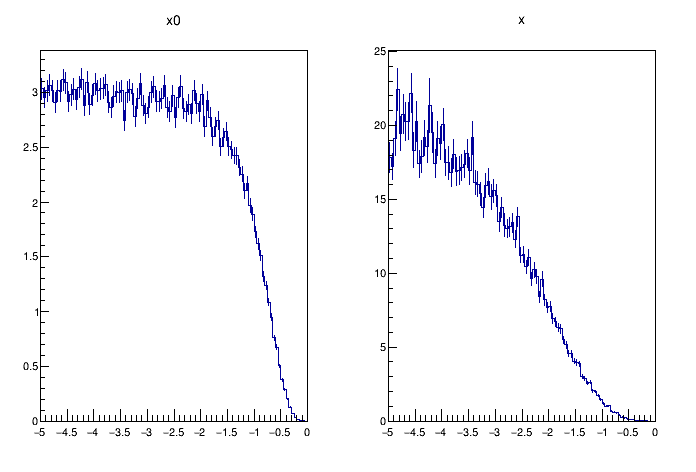

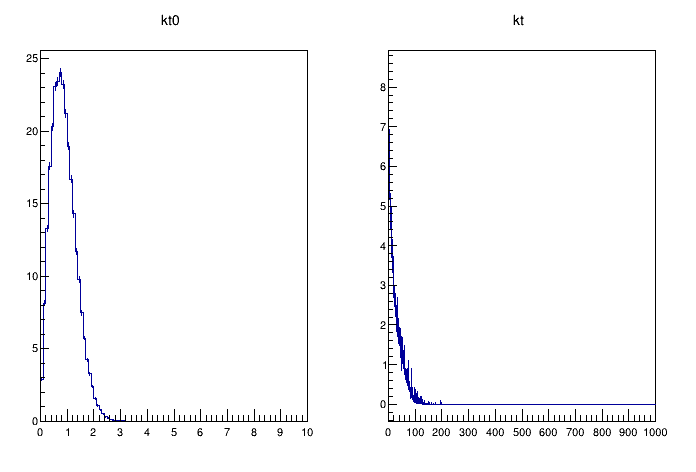

In [10]:
gStyle.SetOptStat(0) # get rid of statistics box
c = TCanvas();
c.Divide(2,1);
c.cd(1);
histo1.Scale(1./npoints, "width");
histo1.Draw("hist e");

c.cd(2);
histo3.Scale(1./npoints, "width");
histo3.Draw("hist e");
c.Draw()
# -

# Plot the $k_T$ distribution in the starting scale and after the evolution

# +
d = TCanvas();
d.SetLogy();
d.Divide(2,1);
d.cd(1);
histo2.Scale(1./npoints, "width");
d.SetLogy();
histo2.Draw("hist e");

d.cd(2);
histo4.Scale(1./npoints, "width");
d.SetLogy();
histo4.Draw("hist e");
d.Draw()